In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.models import alexnet
import numpy as np
import os
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
drive_path = '/content/gdrive/My Drive/clusteringcourse/' # TODO - UPDATE ME!

Mounted at /content/gdrive


# **data preparation**

In [ ]:

#----------------- PRPAERING THE DATA----------------------------

# Define transformations
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
    transforms.RandomRotation(10),  # Randomly rotate the images by 10 degrees
     transforms.RandomCrop(227, padding=4),  # Randomly crop the images with padding
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
path_train= '/content/gdrive/My Drive/clusteringcourse/data/train/'
batch_size= 32
train_data= ImageFolder(root=path_train, transform=transform)
test_data = ImageFolder(root=os.path.join(drive_path, "data/test"), transform=transform)

train_loader = DataLoader(train_data, batch_size=24, shuffle=True)
test_loader = DataLoader(test_data, batch_size=36, shuffle=True)

In [ ]:
#---------- CHECKING DATA------------
# Verify the labels
k=0
for images, labels in train_loader:
   # print(labels)  # This should print a tensor of labels corresponding to the batch of images
    k=k+1
    break # Remove break to see more batches
print(k)

# Print number of images
print(train_loader.dataset.__len__())
print(test_loader.dataset.__len__())
# image shape
data_sample = train_loader.dataset.__getitem__(0)
print(f'data sample shape is: {data_sample[0].shape}, with the label: {data_sample[1]}')
data_sample[0].min(), data_sample[0].max()

1
191
36
data sample shape is: torch.Size([3, 227, 227]), with the label: 0


(tensor(-1.9980), tensor(2.6400))

# **first model:** only AlexNet

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


#----------------- LEARNING----------------------------
# Load pre-trained AlexNet model
model = alexnet(pretrained=False)
model.to(device)
acc=[]
losses=[]
# Modify the classifier for binary classification (healthy vs tumor)
model.classifier[6] = nn.Linear(4096, 2)  # assuming two classes: healthy and tumor

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

num_epochs = 25

model.eval()
correct = 0
total = 0
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
acc.append(accuracy)
print('validation Accuracy: {}%'.format(accuracy))


# Training loop
for epoch in range(num_epochs):
  model.train()
  running_loss =0.0
  iter = 1
  for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      iter+=1
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      print(f'loss iteration {iter}: {loss.item()}')
  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')
  losses.append(running_loss)

  # Evaluation
  model.eval()
  with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          print(f"correct: {labels}")
          print(f"predicted: {predicted}")
      accuracy = 100 * correct / total
      acc.append(accuracy)
      print('validation Accuracy: {}%'.format(accuracy))


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


validation Accuracy: 50.0%
loss iteration 2: 0.6929660439491272
loss iteration 3: 0.6932790875434875
loss iteration 4: 0.6757894158363342
loss iteration 5: 0.6215367913246155
loss iteration 6: 0.7558695673942566
loss iteration 7: 0.7613287568092346
loss iteration 8: 0.6683247685432434
loss iteration 9: 0.665826141834259
Epoch [1/25], Loss: 0.6919
correct: tensor([0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
        0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1])
predicted: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
validation Accuracy: 50.0%
loss iteration 2: 0.6987946033477783
loss iteration 3: 0.6732065677642822
loss iteration 4: 0.6778660416603088
loss iteration 5: 0.6612188816070557
loss iteration 6: 0.666485607624054
loss iteration 7: 0.6503283977508545
loss iteration 8: 0.6612488627433777
loss iteration 9: 0.5138788819313049
Epoch [2/25], Loss: 0.6504
correct: tensor([1, 0, 1, 0, 1, 

Text(0.5, 1.0, 'Train loss during the learning of the AlexNet model')

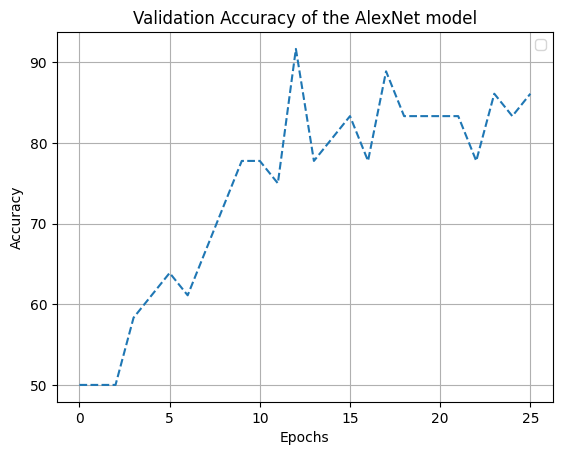

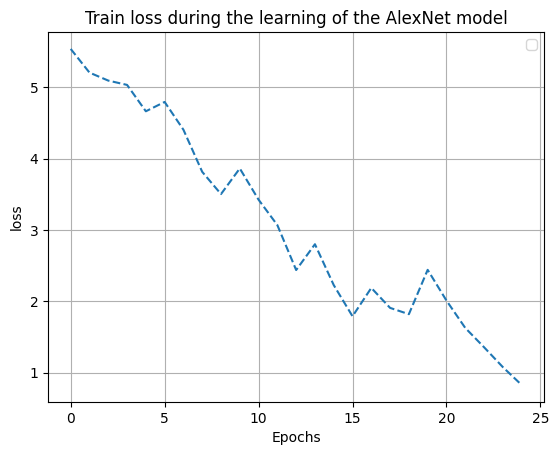

In [ ]:
plt.figure()
plt.plot(np.arange(len(acc)), acc, "--")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.title("Validation Accuracy of the AlexNet model")

plt.figure()
plt.plot(np.arange(len(losses)), losses, "--")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.grid(True)
plt.title("Train loss during the learning of the AlexNet model")

# **Clustering Functions**

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.cluster import KMeans  # Import KMeans

# Function to preprocess image
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (227, 227))
    return image

# Function to flatten image
def flatten_image(image):
    return image.flatten().reshape(-1, 1)

# Function to apply clustering
def apply_clustering(flattened_image, image_shape, n_clusters=10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10).fit(flattened_image)
    clustered_image = kmeans.labels_.reshape(image_shape)
    return clustered_image, kmeans.cluster_centers_

# Function to visualize clustered image
def visualize_clustered_image(clustered_image, image_path):
    plt.imshow(clustered_image, cmap='Greys')
    plt.colorbar()
    plt.title(f'Clustered Image: {os.path.basename(image_path)}')
    plt.show()

# Function to print cluster centers
def print_cluster_centers(centers):
    print("Cluster Centers:")
    for i, center in enumerate(centers):
        print(f"Center {i+1}: {center}")

# Directory containing the images
image_dir_train_healthy = '/content/gdrive/MyDrive/clusteringcourse/data/train/train_healthy/'
image_dir_train_tumor = '/content/gdrive/MyDrive/clusteringcourse/data/train/train_tumor/'
centers_healthy=[]
centers_tumor =[]
# Process all images in the directory
for filename in os.listdir(image_dir_train_healthy):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')):
        image_path = os.path.join(image_dir_train_healthy, filename)
        proc_img = preprocess_image(image_path)
        img = flatten_image(proc_img)
        clustere_image, center_healthy = apply_clustering(img, proc_img.shape, 2)
       # visualize_clustered_image(clustere_image,image_path)
        centers_healthy.append(center_healthy)

for filename in os.listdir(image_dir_train_tumor):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')):
        image_path = os.path.join(image_dir_train_tumor, filename)
        proc_img = preprocess_image(image_path)
        img = flatten_image(proc_img)
        clustered_image, center_tumor = apply_clustering(img, proc_img.shape, 2)
        centers_tumor.append(center_tumor)


#Now doing the Model + Clustering

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


#----------------- LEARNING----------------------------
# Load pre-trained AlexNet model
model = alexnet(pretrained=False)
model.to(device)
acc=[]
losses=[]
# Modify the classifier for binary classification (healthy vs tumor)
model.classifier[6] = nn.Linear(4096, 2)  # assuming two classes: healthy and tumor

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

cluster_num = 5
num_epochs = 30

# Training loop
for epoch in range(num_epochs):
  model.train()
  running_loss =0.0
  iter = 1
  for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      # making clustered photos
      images_lst=[]
      for one_image in images:
       # print(one_image.shape)
        img = flatten_image(one_image)
        cluster_image, _ = apply_clustering(img, one_image.shape, cluster_num)
        cluster_image = torch.tensor(cluster_image,dtype=torch.float32).unsqueeze(0)
        images_lst.append(cluster_image)
      all_images_tensor = torch.cat(images_lst, dim=0)
      all_images_tensor = all_images_tensor.to(device)
      outputs = model(all_images_tensor)
      loss = criterion(outputs, labels)
      iter+=1
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      print(f'loss iteration {iter}: {loss.item()}')
  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')
  losses.append(running_loss)

  # Evaluation
  model.eval()
  with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader:
          images, labels = images.to(device), labels.to(device)
          images_lst=[]
          for one_image in images:
          # print(one_image.shape)
            img = flatten_image(one_image)
            cluster_image, _ = apply_clustering(img, one_image.shape, cluster_num)
            cluster_image = torch.tensor(cluster_image,dtype=torch.float32).unsqueeze(0)
            images_lst.append(cluster_image)
          all_images_tensor = torch.cat(images_lst, dim=0)
          all_images_tensor = all_images_tensor.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          print(f"correct: {labels}")
          print(f"predicted: {predicted}")
      accuracy = 100 * correct / total
      acc.append(accuracy)
      print('validation Accuracy: {}%'.format(accuracy))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


loss iteration 2: 0.6930952668190002
loss iteration 3: 0.6931793689727783
loss iteration 4: 0.6651191115379333
loss iteration 5: 0.6868121027946472
loss iteration 6: 0.6510550379753113
loss iteration 7: 0.7457690834999084
loss iteration 8: 0.6734581589698792
loss iteration 9: 0.6726692318916321
Epoch [1/30], Loss: 0.6851
correct: tensor([1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
        0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0])
predicted: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
validation Accuracy: 50.0%
loss iteration 2: 0.6408047080039978
loss iteration 3: 0.695488691329956
loss iteration 4: 0.6505915522575378
loss iteration 5: 0.7286677360534668
loss iteration 6: 0.7142744064331055
loss iteration 7: 0.6488670706748962
loss iteration 8: 0.6708107590675354
loss iteration 9: 0.684890866279602
Epoch [2/30], Loss: 0.6793
correct: tensor([0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 

In [ ]:
# k = 2

losses_k_2 =[5.541862070560455, 5.486774384975433, 5.416564106941223, 5.291998744010925, 4.963664263486862, 4.694768607616425, 4.520887076854706, 4.368696004152298, 4.492794215679169, 4.12261563539505, 4.380508273839951, 4.2017726600170135, 4.10431981086731, 3.7747923731803894, 3.7952321469783783, 3.9642528295516968, 3.7169919312000275, 3.5510431677103043, 3.8001835346221924, 3.542483299970627, 3.6918215453624725, 3.225301370024681, 3.1726906299591064, 3.1160215735435486, 3.8144341111183167]
accuracies_k_2 =[50.0, 50.0, 50.0, 50.0, 52.77777777777778, 61.111111111111114, 77.77777777777777, 77.77777777777777, 58.333333333333336, 80.55555555555556, 77.77777777777777, 66.66666666666667, 77.77777777777777, 63.888888888888886, 75.0, 52.77777777777778, 66.66666666666667, 63.888888888888886, 55.55555555555556, 52.77777777777778, 61.111111111111114, 61.111111111111114, 55.55555555555556, 61.111111111111114, 52.77777777777778]


[5.48115736246109, 5.434395790100098, 5.357318699359894, 5.214704692363739, 4.711535722017288, 5.190262347459793, 4.757703125476837, 4.974449634552002, 4.3159215450286865, 4.620762854814529, 4.543078720569611, 4.414493411779404, 4.485174208879471, 4.371708691120148, 4.149819105863571, 4.34798526763916, 4.216874301433563, 4.100334018468857, 4.095981776714325, 4.217790573835373, 3.945653051137924, 4.507527023553848, 4.451566398143768, 4.289686501026154, 4.27073809504509, 4.328568011522293, 4.236872375011444, 4.513049602508545, 4.2808603048324585, 4.022538900375366]
[50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 58.333333333333336, 61.111111111111114, 69.44444444444444, 72.22222222222223, 80.55555555555556, 80.55555555555556, 83.33333333333333, 72.22222222222223, 77.77777777777777, 77.77777777777777, 77.77777777777777, 72.22222222222223, 77.77777777777777, 86.11111111111111, 75.0, 75.0, 77.77777777777777, 77.77777777777777, 80.55555555555556, 86.11111111111111, 77.77777777777777, 75.0, 77.777777777

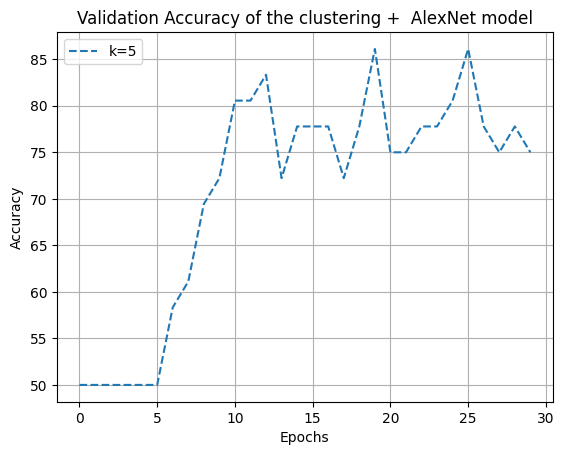

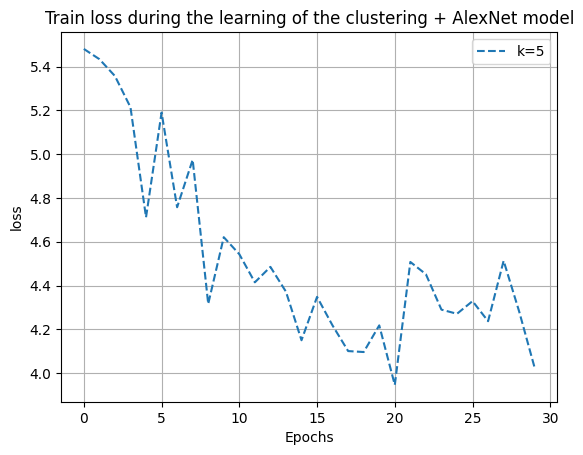

In [ ]:
plt.figure()
plt.plot(np.arange(len(acc)), acc, "--", label = "k=5")
#plt.plot(np.arange(len(accuracies_k_2)), accuracies_k_2, "--", label = "k=2")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.title("Validation Accuracy of the clustering +  AlexNet model")

plt.figure()
plt.plot(np.arange(len(losses)), losses, "--", label ="k=5")
#plt.plot(np.arange(len(losses_k_2)), losses_k_2, "--", label = "k=2")

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.grid(True)
plt.title("Train loss during the learning of the clustering + AlexNet model")
print(losses)
print(acc)


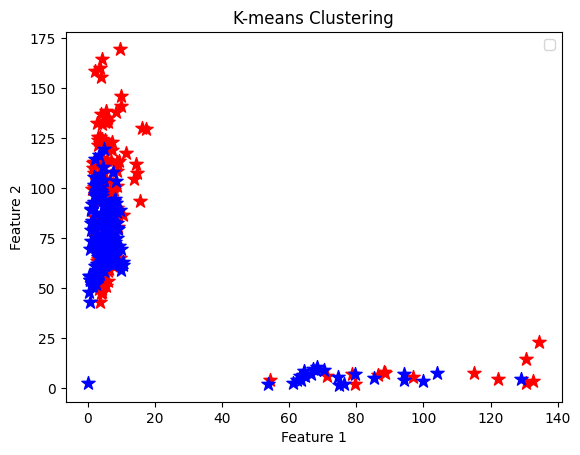

In [ ]:

# Plot the cluster centers
plt.scatter(np.array(centers_healthy)[:, 0], np.array(centers_healthy)[:, 1], c='red', marker='*', s=100)
plt.scatter(np.array(centers_healthy)[:, 0], np.array(centers_healthy)[:, 1], c='red', marker='*', s=100)

#plt.scatter(np.array(centers_tumor)[:, 0], np.array(centers_tumor)[:, 1], c='blue', marker='*', s=100)

# Add title and labels
plt.title('K-means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()


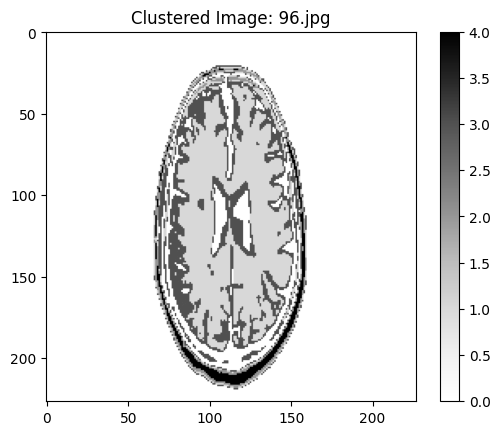

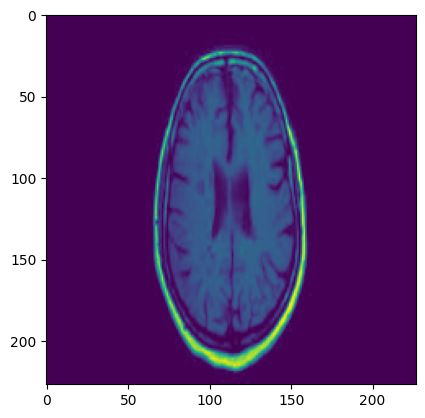

In [ ]:
# Example usage:
image_path = '/content/gdrive/MyDrive/clusteringcourse/data/train/train_healthy/96.jpg'
proc_img = preprocess_image(image_path)
img = flatten_image(proc_img)
clustered_image, centers = apply_clustering(img, proc_img.shape,5)

# Visualize clustered image
visualize_clustered_image(clustered_image, image_path)
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (227, 227))
plt.imshow(image)



